# INF8111 - Fouille de données


## TP2 Automne 2019 - Extraction et analyse d'une base de données de tweets

##### Membres de l'équipe:

    - Claudia Onorato (1845448) 1
    - William Harvey (1851388) 2
    - Jérémie Miglierina (Matricule) 3

## Présentation du problème

En 2017, Twitter compte 313 millions d’utilisateurs actifs par mois avec 500 millions de tweets envoyés par jour. Cette information est rendue disponible à destination de la recherche et du développement web grâce à une API publique qui permet de collecter les informations que l'on souhaite.

Néanmoins, la politique de développement de Twitter limite le partage de ces données. En effet, le partage du contenu des tweets dans une base de données n'est pas autorisé, seuls les identifiants des tweets le sont. 
Pour partager publiquement une base de données de tweets que l'on a créée, il faut que cette base de données ne soit consituée que des identifiants de tweets, et c'est ce que l'on retrouve dans la plupart des jeux de données publiques.

Il est donc nécessaire pour exploiter ces données "d'hydrater" les tweets en question, c'est-à-dire extraire l'ensemble des informations à partir de l'ID, ce qui demande d'utiliser l'API de Twitter.

Nous allons ici utiliser des bases de données publiques créées par GWU (George Washington University), qui ont l'avantage d'être très récentes : 
https://dataverse.harvard.edu/dataverse/gwu-libraries

Chaque base de données de GWU couvre un sujet précis (élection américaine de 2016, jeux olympiques, etc.), et les données ont été recueillis en appliquant des requêtes qui filtraient les résultats pour n'avoir que des tweets pertinents. Un fichier README est fourni avec chaque base de données pour donner les détails de création du *dataset*. 


**Les objectifs de ce TP sont donc les suivants :**

 1. Construire un *crawler* qui collecte les informations d'un tweet à partir de son ID, avec le jeu de données de son choix et les informations pertinentes pour le sujet choisi
 2. A partir de ces données de Twitter collectés, application de méthodes en Machine Learning (ML)/Natural Language Processing (NLP) pour fournir une analyse pertinente. 


Twitter autorisant le partage **local** des données (par exemple au sein d'un groupe de recherche), une base de données sera fournie si vous ne parvenez pas à créer la vôtre.

# I/ Hydratation de tweets à l'aide de l'API Twitter (4 Pts)

### 1. Obtenir l'authorisation de Twitter pour l'utilisation de l'API

Pour l'authentification, Twitter utilise OAuth : https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
Vous aurez ici besoin en particulier de OAuth2, car vous n'allez pas interagir avec des utilisateurs sur Twitter (simplement collectés des données).

##### 1.1. Obtention d'un compte Twitter développeur

 La première étape nécessaire pour enregistrer votre application et de créer un compte Twitter développeur. Pour ce faire :

 - Créez un compte Twitter classique si vous n'en avez pas déjà un.
 
 - Sur le site, https://developer.twitter.com, cliquez sur *apply* pour obtenir un compte développeur. 
 
 - Remplissez tous les champs nécessaires. Twitter demande beaucoup de détails sur l'utilisation que vous allez faire de ce compte, il est donc important d'expliquer la démarche en détail : il faut souligner le fait que le projet est **académique** (aucune intention commerciale, aucune publication des données collectés, etc.), expliquer les objectifs et l'apprentissage de ce TP (prise en main de l'API Twitter, l'application concrète de méthodes de Data Mining, etc.), mais aussi expliquer en détail ce que vous allez faire des données (en reprenant des consignes du sujet), les méthodes que vous allez appliquer (citez des méthodes vues en cours ou au précédent TP), le rendu fourni (insistez sur le fait que rien ne sera publique), etc. Pensez notamment à indiquer le nom du cours et le sigle du cours, le nom de l'établissement, mon nom (Théo Moins), etc. Cochez que vous n'utiliserez pas la fonctionnalité de Retweet, et que l'aggregation et l'affichage de tweets ne sera fait que dans un cadre pédagogique (non publique, et sous la forme d'un projet de recherche). Si jamais vous n'êtes pas assez précis, Twitter peut vous renvoyer un courriel pour vous demander des précisions. 

##### 1.2. Obtention d'un jeton d'accès

 - Lorsque Twitter aura validé votre demande de compte développeur, allez sur https://developer.twitter.com/en/apps pour créer une application (cliquer sur *create an app*)

- Ici encore, des informations sont à fournir ici. Certaines, comme le nom ou le site internet, ne sont pas très importante, vous pouvez mettre un site internet factice si vous le souhaitez.

- A la fin de ce processus, vous pouvez enfin obtenir les clés et les jetons pour utiliser l'API: allez sur la page de l'application pour créer les jetons. Vous devez récupérer une paire de clés et une paire de jetons pour passer à la suite.



In [1]:
CONSUMER_KEY = "GlHxKShmO5b9OEsQ4Dt0zvyOX"
CONSUMER_SECRET = "vI2oo6y2MvDfXExtqksciUpEOQQjKjFjYro4gqYLygRf88Bf4x"

oauth_token = "1130485290836078592-4QoIqjpbH5dwxiFzwsJJI0HI6QJoZX"
oauth_secret = "4AIWHfRlEwZ8EFSSZ945tsFaSlijDzhlEGcTWogPfdrBl"

###  2. Premiers pas avec Twython

##### 2.1 Installation et import de la librairie


Plusieurs librairies Python existent pour manipuler l'API Twitter. Aussi appelé *wrappers*, ce sont un ensemble de fonctions python qui appelle des fonctions de l'API. Parmi elles, nous utiliserons Twython, librairie répendue et activement maintenue.

Documentation de Twython : https://twython.readthedocs.io/en/latest/api.html 

In [2]:
import csv
import time
import sys
try:
    from twython import Twython, TwythonError, TwythonRateLimitError
except ImportError:
    !pip install --user twython

##### 2.2 Création d'une application et premiers tests:

In [3]:

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

Voici un test avec une recherche très simple pour vous assurer que la requête fonctionne.

La fonction search renvoie une recherche (non exhaustive) de tweets, et l'option "*popular*" permet de retourner les résultats les plus populaires de la réponse. (documentation ici: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets)

In [4]:
basic_search = twitter.search(q='python', result_type='popular')

La fonction `search` renvoie un dictionnaire contenant la liste de tweets de la requête, et les métadonnées.

Voici un exemple d'un résultat d'une recherche, observez ainsi toutes les données/métadonnées que contient un tweet et que vous pouvez extraire par la suite:

In [ ]:
test_id = "1157345692517634049"
tweet = twitter.show_status(id = test_id)
print("Contenu: " + tweet['text'])
print("Date: " + tweet["created_at"])
print("Utilisateur: " + tweet["user"]["screen_name"])



Contenu: A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
Date: Fri Aug 02 17:41:30 +0000 2019
Utilisateur: realDonaldTrump


In [6]:
basic_search['statuses'][0]

{'created_at': 'Sat Nov 09 16:00:00 +0000 2019',
 'id': 1193196549632856064,
 'id_str': '1193196549632856064',
 'text': '#OnThisDay 1979: John Cleese, Michael Palin, Malcolm Muggeridge and the Bishop of Southwark memorably discussed Mon… https://t.co/4DWjcj8uSx',
 'truncated': True,
 'entities': {'hashtags': [{'text': 'OnThisDay', 'indices': [0, 10]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/4DWjcj8uSx',
    'expanded_url': 'https://twitter.com/i/web/status/1193196549632856064',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'metadata': {'result_type': 'popular', 'iso_language_code': 'en'},
 'source': '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 51023770,
  'id_str': '51023770',
  'name': 'BBC Archive',
  '

Il est également possible avec Twython de récupérer les informations d'un tweet à partir de son ID. 

#### Question 1. Afficher la date, le nom d'utilisateur et le contenu du tweet ayant l'ID : 1157345692517634049 (0.5 Pts)

*Indice : vous pourrez utiliser avec la fonction de twython `show_status`*

**Attention** : Twitter a une limitation de requête par fenêtre de 15 minutes, qui est donc à prendre en compte dans la base de données : https://developer.twitter.com/en/docs/basics/rate-limiting.html

### 3. Hydratation d'une base de donnée de tweets

Les choses sérieuses commencent ! 

On souhaite désormais construire une fonction `hydrate_database` qui, à partir d'un fichier texte contenant une liste d'ID de tweets, créer un fichier csv contenant les informations que l'on souhaite extraire. 

Due à la limitation de requête, la fonction `show_status` vue plus haut s'avère peu efficace pour cette tâche : à raison de 900 requêtes pour 15 minutes, il sera beaucoup trop long de construire une base de données un tant soit peu conséquente. La fonction `lookup_status` (voir documentation) sera donc plus adaptée. Elle permettra d'hydrater 100 tweets par requête, ce qui, a raison d'une limite de 900 requêtes pour 15 minutes, rends la construction de la base de données plus réaliste. Il faudra tout de même gérer l'erreur générer par la limitation, si l'on souhaite avoir plus de 90000 tweets ou si l'on appelle plusieurs fois la fonction en moins de 15 minutes.

#### Question 2. Implémenter la fonction `hydrate_database` (3.5 Pts)

*Attention : Il faut également gérer le cas où la feature demandée n'est pas une clé du dictionnaire mais une "sous-clé", comme c'est le cas pour le nom d'utilisateur par exemple (accessible dans la feature *user*, qui lui même est un dictionnaire). Un moyen simple pour pallier à ce problème consiste à considérer la feature comme une liste, qui contiendrait la clé et les sous-clés si il y a lieu (voir exemple plus bas)

*Indice : La fonction `sleep` du module time permet de patienter le temps nécessaire*

In [7]:
def find_value_by_keys(dictionary, keys):
  """ This finds the value of imbricated keys in a dictionary. """
  if len(keys) != 1:
    return find_value_by_keys(dictionary[keys[0]], keys[1:])
  else:
    return dictionary[keys[0]]

def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit = 100):
    """
    Create a csv file that contains features of tweets from an file that contains ID of tweets.
    
    filename: Name of the file that contains ids
    database_name: name of the file that will be created
    features: List of features
    nb_requests: number of time the function lookup_status will be called
    tweet_hydratation_limit:
    """
    # Opening the ID File:
    file = open(filename, "r")
    
    # Creation of the file that will contain the hydrated tweets:
    with open(database_name, 'w', newline='', encoding="utf-8") as csvfile:
      csv_writer = csv.writer(csvfile)
      headers = ["-".join(list_features) for list_features in features]
      print(headers)
      csv_writer.writerow(headers)
  
      try: # If you don't reach the limit of requests
          content = file.readlines()                
          index = 0

          # you may also want to remove whitespace characters like `\n` at the end of each line
          content = [x.strip() for x in content]

          for request in range(nb_requests):
            requested_id = content[request*tweet_hydratation_limit: request*tweet_hydratation_limit + tweet_hydratation_limit + 1] 
            batch_hydrate = twitter.lookup_status(id = requested_id)
            filtered_batch_hydrated = []
            print('Requested %i tweets and received %i.' % (tweet_hydratation_limit, len(batch_hydrate)))
            for tweet in batch_hydrate:
              filtered_tweet = []
              for feature in features:
                filtered_tweet.append(find_value_by_keys(tweet, feature))
              filtered_batch_hydrated.append(filtered_tweet)

            csv_writer.writerows(filtered_batch_hydrated)
            
      except TwythonError as e:
          if isinstance(e, TwythonRateLimitError):
              retry_after = int(e.retry_after)
              print('Rate Limit busted! Waiting for %i seconds before retrying' % retry_after)
              time.sleep(retry_after)

      except Exception as e:
        print(e.message)
              
    file.close()
 

Utilisez le fichier suivant en guise d'example : 
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/5QCCUU/QPYP8G&version=1.1

On suppose qu'on ne souhaite garder que le texte (*text*) l'ID de l'utilisateur (*user/screen_name*)

In [11]:
filename = "TP2/gwu/tweet_news1.txt"
database_name = "TP2/data/news_outlets1.csv"
features = [['text'], ['user', 'screen_name'],['lang'],["created_at"]]
nb_requests = 500

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=99)

['text', 'user-screen_name', 'lang', 'created_at']
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 99.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 99.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Requested 99 tweets and received 88.
Requested 99 tweets and received 100.
Requested 99 tweets and received 100.
Re

# II/ Analyse d'une base de données au choix (16 pts)

Maintenant que vous êtes en mesure d'hydrater une base de données de tweets efficacement et en prenant en compte les limitations de Twitter, vous pouvez l'appliquer sur le *dataset* qui vous intéresse le plus.

### 1. Instructions

Dans cette partie, vous allez mener **entièrement** de vous-même un projet de *Data Science*, c'est à dire de la collecte des données jusqu'à l'interprétation des résultats. 3 sujets sont proposés, vous devez choisir celui qui vous intéresse le plus parmi :
 
 1. Analyse de sentiments pour la prédiction des résultats de l'élection américaine. 
    
    **Dataset :** "2016 United States Presidential Election Tweet Ids", https://doi.org/10.7910/DVN/PDI7IN  
    
    **Précision :** Ce sujet est assez similaire au TP1 (avec ici sentiment = parti politique), vous êtes donc libre de reprendre ce que vous aviez fait. Cependant, il faudrait aller un peu plus en profondeur ici, par exemple sur l'étape de la classification. De plus, vous avez ici une nouvelle problématique qui est que vos données ne sont pas labellisés (mais la construction des collections devrait vous permettre de labelliser vous-même).
 
 
 2. Détection de discours d'incitation à la haine.
    
    **Dataset :** Modifier votre fonction d'hydratation en utilisant la fonction search pour n'avoir que des tweets récents.
 
     **Précision :** Ce sujet pourrait également être abordé de la même manière que le TP1 : des étapes de preprocessing + de la classification. Néanmoins, dans ce cas, posséder des données avec des labels "incitant à la haine"/"n'insite pas à la haine" est beaucoup plus complexe, car beaucoup de bases de données étiquetés, lors de l'hydratation, se trouveront être quasi-vide, car les tweets auront été supprimés au moment où nous ferons notre requête (car Twitter veille aussi à la suppression de tweets haineux). C'est pourquoi vous êtes obligés de créer une base de données avec des tweets les plus récents possibles, avant qu'ils ne soient potentiellement supprimés. Pour désigner un tweet comme haineux, une méthode serait la détection de vocabulaire haineux, par exemple avec `hatebase.org`, qui propose des larges bases de données très complètes. Vous pouvez créer un compte sur le site pour avoir accès à l'API, et ensuite utiliser cette librairie pour Python : https://github.com/DanielJDufour/hatebase. En modifiant la requête pour n'avoir que des tweets contenant ce vocabulaire, et en le mêlant à de l'analyse de sentiment, vous pourrez obtenir des résultats à analyser. Vous pourriez aussi avoir une approche "utilisateur" pour rechercher des tweets haineux : lorsqu'un tweet est détecter comme haineux, inspecter l'ensemble des tweets de l'utilisateur et/ou de ses *followers*. En bref, beaucoup de possibilités, mais ce sujet est le plus complexe des trois. Je serai donc moins exigeant sur les résultats 'chiffrés', l'important ici étant plus l'analyse, et le fait d'avoir une approche cohérente (il est également très important de prendre le temps de réfléchir à une définition claire de "haineux").


 3. Méthodes de clusterings appliqué au tweet sur l'actualité, et analyse des résultats. 
    
    **Dataset :** "News Outlet Tweet Ids", https://doi.org/10.7910/DVN/2FIFLH

    **Précision :** Application de méthodes de preprocessing, puis de méthodes de clustering pour regrouper les tweets qui mentionnent la même actualité ou catégorie d'actualité (au choix!), puis visualisation, étude en fonction du temps...  Vous devrez trouver quelle est la meilleur méthode de clustering, et celle-ci dépendra de votre approche (nombre de classes connu ? si oui, combien de classes?). 
    
    
Vous êtes entièrement libre sur l'ensemble du processus (choix des informations extraites, méthodes en ML, librairie, etc.). Ici seul les bases de données en elle-même sont rigoureusement imposés. Les précisions faites ici servent juste pour vous guider un peu si vous le souhaitez, mais si vous avez d'autres idées n'hésitez pas ! Ces sujets étant populaires au sein de la communauté scientifique, vous pouvez (**seulement si vous le souhaitez**) vous inspirer d'articles de la littérature, à condition de le citer dans votre rapport et de faire votre propre implémentation. 

#### L'objectif cependant ici n'est pas d'obtenir l'état de l'art, mais d'appliquer une méthodologie claire et rigoureuse que vous aurez construite vous-même. 

Les datasets étant massifs, il est fortement déconseillé de faire une base de données contenant tous les tweets hydratés (par exemple, les auteurs de la BDD n°1 soulignent qu'avec les limitations de l'API cela vous prendrait environ 32 jours). C'est à vous de voir quelle est la taille du dataset dont vous avez besoin.

Pensez aussi à lire le fichier README correspondant à la base que vous avez choisi, afin de vous aider à mieux comprendre vos futurs résultats.

### 2. Rédaction d'un rapport

Pour ce TP, vous allez devoir fournir un rapport qui détail et justifie l'ensemble de votre méthode, et qui fournisse les résultats que vous avez obtenus. Les éléments suivants doivent y apparaitre (cela peut vous servir de plan, mais ce n'est pas rigide) :

- Titre du projet, et nom de l'ensemble des membres de l'équipe (avec mail et matricule)
    
- **Introduction** : résumé du problème, de la méthodologie et des résultats obtenus.

- **Présentation du dataset** : description, justification de la taille, du choix des features, etc. 

- **Preprocessing** : s'il y en a, justification des étapes de preprocessing.

- **Methodologie** : description et justification de l'ensemble des choix (algorithmes, hyper-paramètres, régularisation, métriques, etc.)

- **Résultats** : analyse des résultats obtenus (utilisez des figures pour illustrer), mise en relation entre les choix de design et la performance obtenue.

- **Discussion** : discutez des avantages et des inconvénients de votre approche; quels sont les faiblesses, les failles ? Qu'est-ce qu'il peut être amélioré ? Vous pouvez également suggérer des futures idées d'exploration.

- **Références** : si vous vous êtes inspiré d'une étude déjà faite.
    
Vous pouvez utiliser le template d'arXiv pour le rapport : https://fr.overleaf.com/latex/templates/style-and-template-for-preprints-arxiv-bio-arxiv/fxsnsrzpnvwc. **L'ensemble du rapport ne doit cependant pas excéder 5 pages, figures et références compris.** Les 5 pages ne sont pas obligatoires, si vous estimez que moins est suffisant et que votre rapport est effectivement complet, vous ne serez pas pénalisé.


### 3. Rendu attendu

A la fin du TP, vous soumettrez un fichier *zip* contenant les éléments suivants:

- Le fichier *pdf* du rapport
- Ce notebook que vous aurez complété. Vous pouvez également implémenter votre méthode à la suite ici, ou alors utiliser un autre fichier si vous le souhaitez. Bien que seul le rapport servira pour la notation, ayez un code commenté et clair !
- Ne pas envoyer les fichiers de données, car trop conséquent. Avec le rapport et le code, tout sera détaillé et il sera possible de les refaire facilement.

### 4. Evalutation

12 points de cette partie sera basé sur la méthodologie, et 4 points sur les résultats.

La notation sur la méthodologie inclus : 

- La pertinence de l'ensemble des étapes de l'approche

- La bonne description des algorithmes choisis

- La justification judicieuse des choix établis

- Une analyse pertinente des résultats

- La clarté et l'organisation du rapport (figures, tables) et du code.


Pour ce qui est des résultats, il est impossible de mettre un barème fixe car ils vont dépendre du sujet que vous allez choisir. C'est un problème auquel vous serez confrontés : chaque étude étant spécifique, il peut être compliqué d'évaluer qualitativement un modèle, d'autant que vous n'avez sans doute pas connaissance de l'état de l'art. C'est pourquoi il va être important de faire plusieurs essais, et de comparer différentes méthodes. Ainsi, les résultats doivent être cohérent avec la complexité de votre implémentation : un modèle simple et naïf vous fournira des premiers résultats, que vous devrez ensuite améliorer avec des modèles plus précis et complexes.

De ce fait, l'ensemble des points pour les résultats seront donnés si : 
 - Vous obtenez des premiers résultats avec une méthode naïve qui témoignent de la pertinence de vos choix 
 - Ces résultats sont ensuite améliorés avec une méthode plus complexe
 

## 1. Jeu de données


In [81]:
## Read all tweetcontent in csv and put it in a Matrix
import csv
from sklearn.model_selection import train_test_split

def load_dataset(path):
    
    x = []

    with open(path, 'r', newline='', encoding="latin-1") as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_text = header.index('text')
        index_language = header.index('lang')
        
        for row in reader:
            if row[index_language] == "en":
                x.append(row[ind_text])

        return x


# Path of the dataset
path = "data/news_outlets1.csv"

X = load_dataset(path)
train_X = X

print("Length of training data_set : ", len(train_X))
for tweet in train_X[50:58]:
    print(tweet)

Length of training data_set :  40419
RT @usatodaylife: And the title of the new #StarWars movie is... https://t.co/3U4duQN4lr
Rosneft signs production sharing agreements for Kurdistan oil fields https://t.co/yIbj3DNWmR
#BREAKING Dow tops 23,000 for the first time but closes just shy of the milestone https://t.co/dJxUQFdLQe
Georgia fashion designer Mychael Knight, 39, died outside Atlanta surrounded by family and friends. https://t.co/G18l7g5mKn
Oil pares gains after gasoline inventories rose more than expected https://t.co/CgpTjIXyX8
#Live: President Trump speaks at the Heritage Foundationâs Presidentâs Club Meeting https://t.co/vzxoVx3MWS
RT @usatodaysports: The NBA season begins with a thriller. https://t.co/ua6HxIfPjm
Oil prices buoyed by Kurdish and Iraq tension, say leading traders https://t.co/UpSTKwrQ7y


## 2. Pre-Processing


### Twitter Pre-Processing utilisant des expressions régulières

In [82]:
import re

def remove_retweets(tweets):
    """
    Removes RT at the beginning of messages
    """
    resultTweets = []
    for tweet in tweets:
        if tweet.split(' ', 1)[0] == "RT":
              resultTweets.append(tweet.split(' ', 1)[1])
        else:
              resultTweets.append(tweet)
    return resultTweets

def remove_HTTP_links(tweets):
    """
    Removes all HTTP and HTTPS links
    """
    return [re.sub(r"http\S+", "", tweet) for tweet in tweets]

def remove_mentions(tweets):
    """
    Removes all mentions including the mentioned user nametag
    """
    resultTweets = []
    for tweet in tweets:
        mentions = re.findall("@[\w]*", tweet)
        for mention in mentions:
            tweet = re.sub(mention, "", tweet)
        resultTweets.append(tweet)

    return resultTweets       

def remove_non_letter_characters(tweets):
    """
    Removes all characters that is not a letter or a hashtag, because we only want to analyze texts.
    """
    return [re.sub("[^a-zA-Z#]", " ", tweet) for tweet in tweets]
    
def remove_white_spaces(tweets):
    """
    Removes all whitespace characters (tabs, newline, spaces) and only puts one space
    """
    return [" ".join(tweet.split()) for tweet in tweets]

def remove_hashtag_character(tweets):
    """
    Removes the '#' character from the tweets
    """
    return [re.sub("[#]", "", tweet) for tweet in tweets]

test = ["RT https://dhksdgkjsdghsa.com allo https://dhksdgkjsdghsa.com", "RT allo un peu oue", "allo claudia https://dhksdgkjsdghsa.com ", "RT @claudia: blabal", "allo @claudia #hihi, aj bla @jérémie"]

train_X = remove_HTTP_links(train_X)
train_X = remove_retweets(train_X)
train_X = remove_mentions(train_X)
train_X = remove_non_letter_characters(train_X)
train_X = remove_white_spaces(train_X)
train_X = remove_hashtag_character(train_X)

print(train_X[50])

And the title of the new StarWars movie is


## 3. TF-IDF


In [83]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt
import matplotlib.cm as cm

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,          # Act as a stopword filter
    max_features = 8000,
    lowercase = True,
    tokenizer = LemmaTokenizer()
    #stop_words = 'english' # There are several known issues in our provided ‘english’ stop word list. (see docs)
)
tfidf.fit(train_X)
text = tfidf.transform(train_X)

range(2, 51, 2)
Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


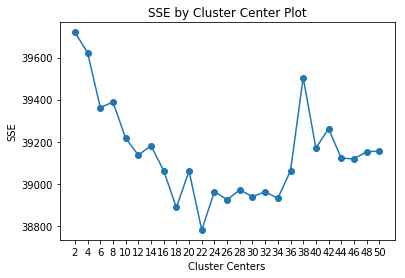

In [84]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    print(iters)
    
    sse = []
    for k in iters:
        # 
        sse.append(MiniBatchKMeans(init = "k-means++",n_clusters=k,random_state= 0, init_size=None).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 50)

In [85]:
# Clusters contain an array of size N_TWEETS where each element is the index of the corresponding cluster
N_CLUSTERS = 22
clusters = MiniBatchKMeans(init = "k-means++",n_clusters=N_CLUSTERS,random_state= 0, init_size=None).fit_predict(text)

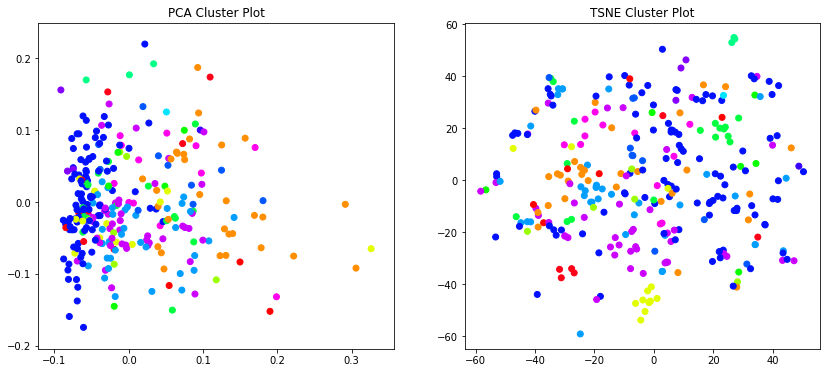

In [86]:
import numpy as np

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
    

In [ ]:
import pandas as pd

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), N_CLUSTERS)

## WordCloud

In [46]:
from wordcloud import WordCloud

def print_word_cloud(n_clusters, cluster_list, tweets):
    """
    Prints the wordcloud for each cluster.
    n_clusters: Number of clusters
    cluster_list: Array with n_tweets elements, where each element identifies the corresponding tweet cluster.
    tweets: Array of n_tweets string, where each string is the preprocessed tweet.
    """

    for cluster_no in range(n_clusters):
        cluster_tweet_indexes = [i for i, cluster in enumerate(cluster_list) if cluster_no == cluster]
        all_tweets_of_cluster = ' '.join([train_X[index] for index in cluster_tweet_indexes])

        wordcloud = WordCloud(width=800, height=500, random_state=30, max_font_size=110).generate(all_tweets_of_cluster)

        plt.figure(figsize=(8, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Wordcloud for cluster {cluster_no} with {len(cluster_tweet_indexes)} tweets')
        plt.show()

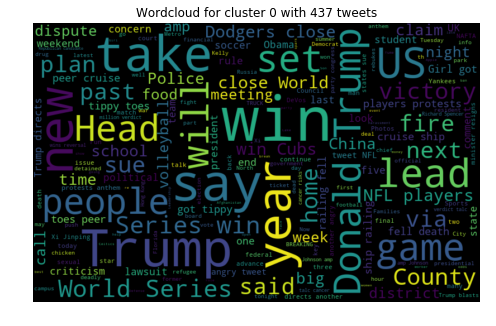

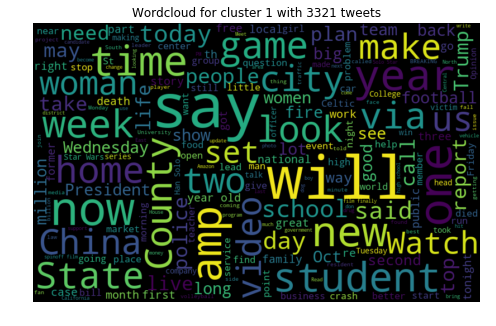

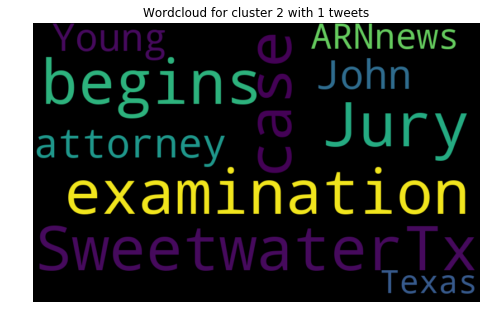

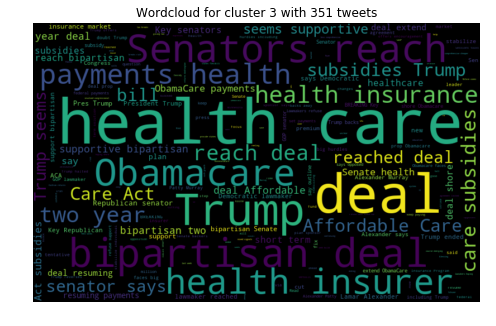

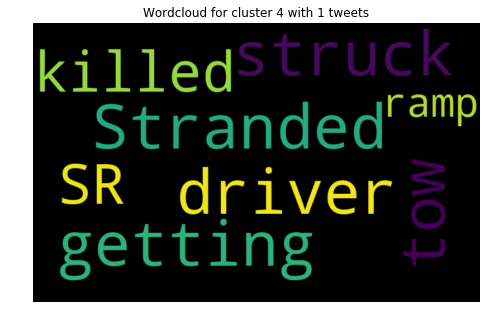

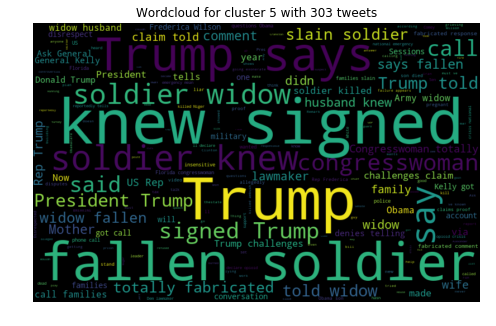

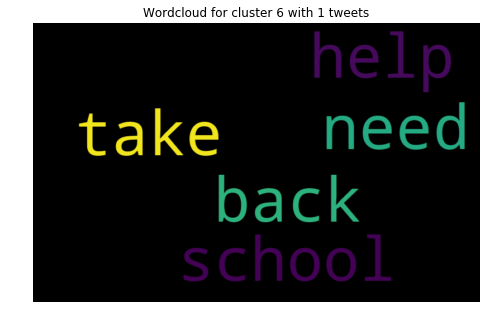

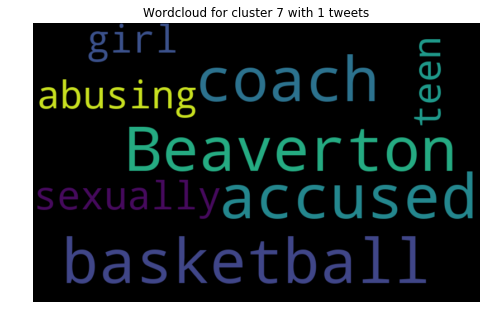

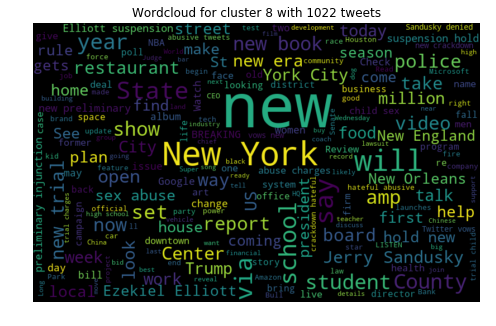

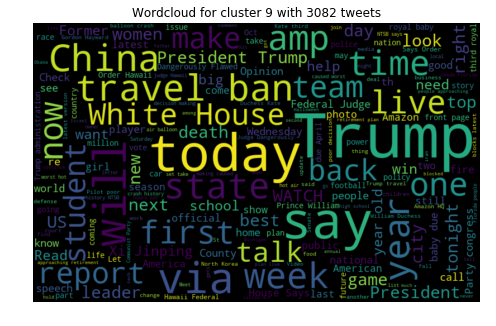

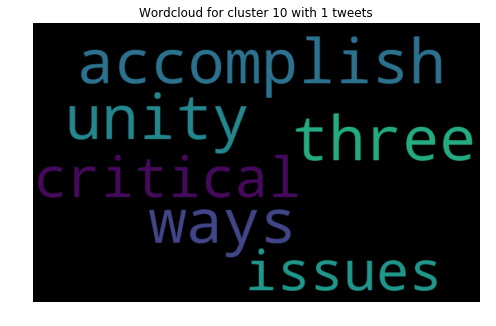

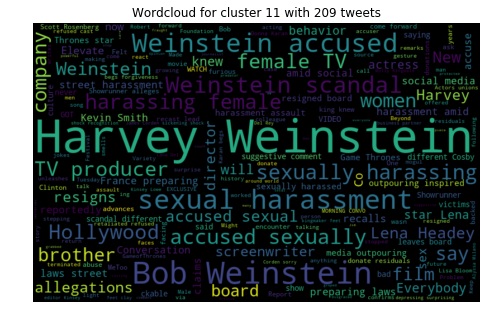

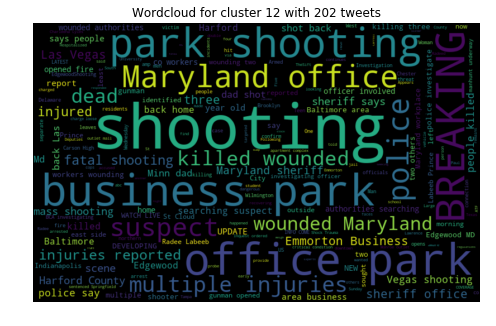

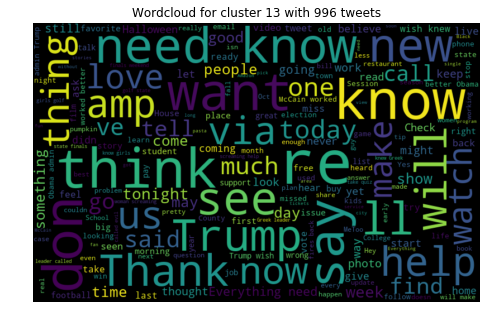

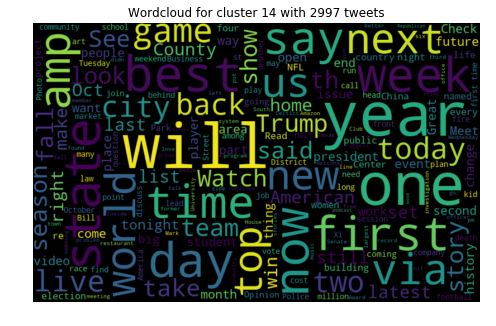

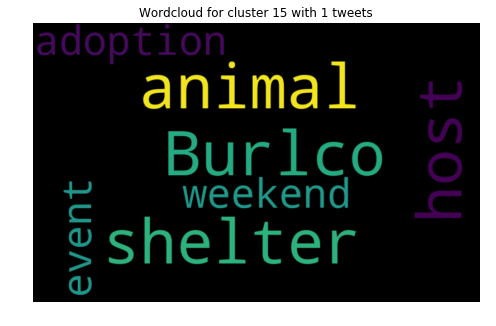

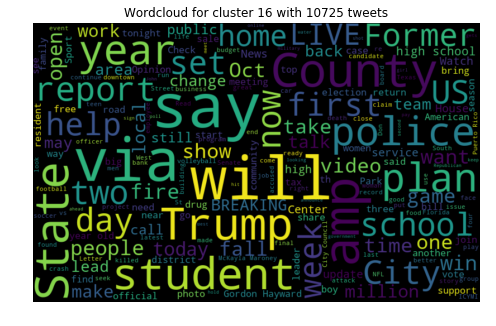

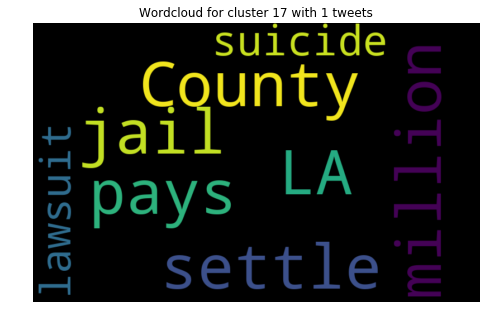

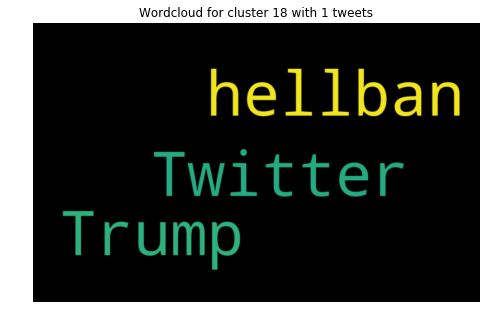

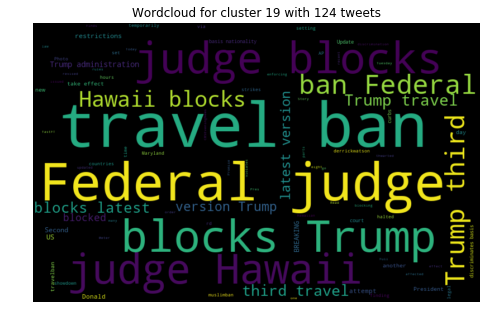

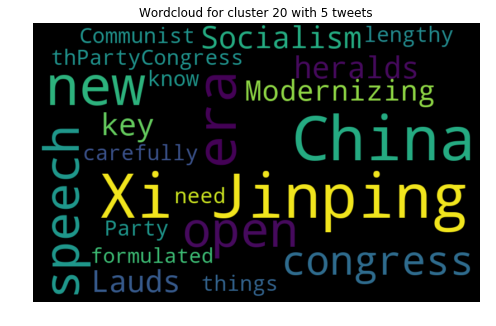

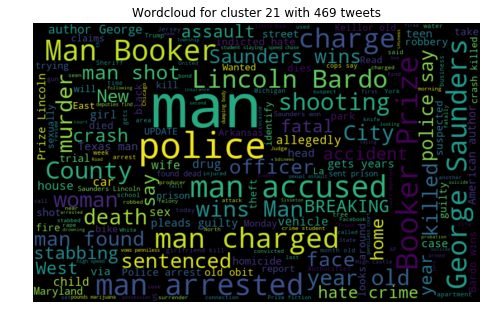

In [47]:
print_word_cloud(N_CLUSTERS, clusters, train_X)

## Histograms

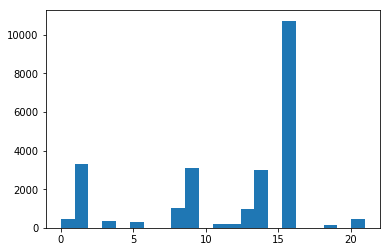

In [48]:
plt.hist(clusters, bins=N_CLUSTERS)
plt.show()

## Time Analysis

In [17]:
from pytz import timezone
from datetime import datetime


eastern = timezone('US/Eastern')
utc = timezone('UTC')

created_at = datetime.strptime(tweet[0]['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
utc_created_at = utc.localize(created_at)
print(utc_created_at)
est_created_at = utc_created_at.astimezone(eastern)
print(est_created_at)

TypeError: ignored

## DBSCAN

24251


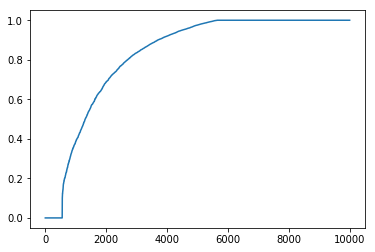

In [80]:
from sklearn.neighbors import NearestNeighbors

print(len(text.todense()))

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(text)
distances, indices = nbrs.kneighbors(text)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances[4000:14000])

In [75]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.98, min_samples = 10, metrics)
dbscan.fit(text)

DBSCAN(algorithm='auto', eps=0.98, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [76]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise_ = list(dbscan.labels_).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 73
Estimated number of noise points: 22493


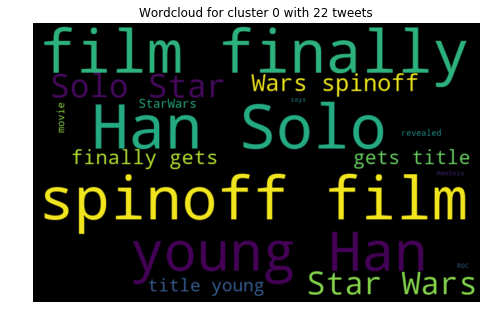

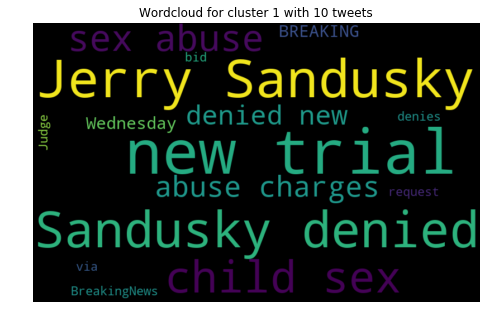

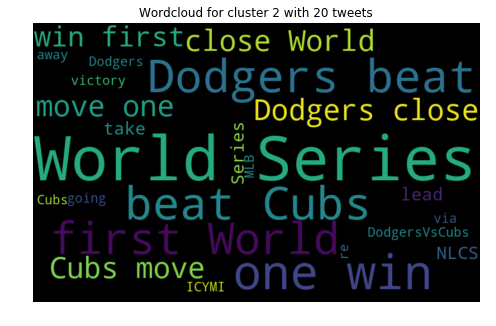

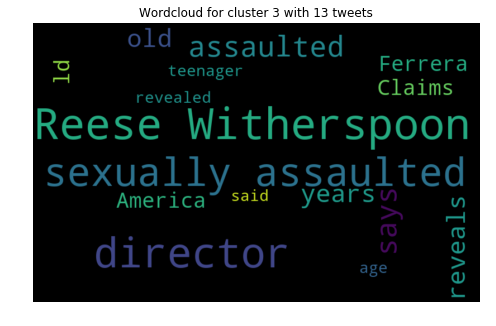

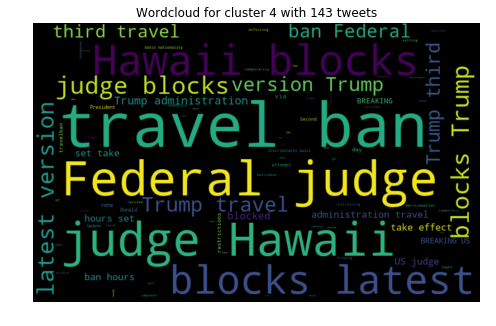

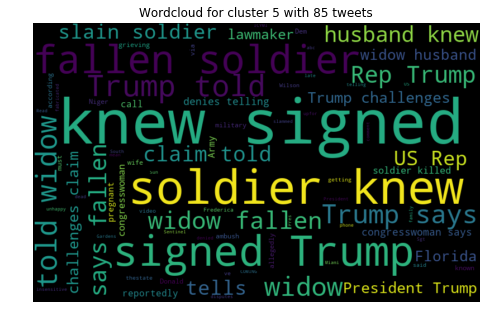

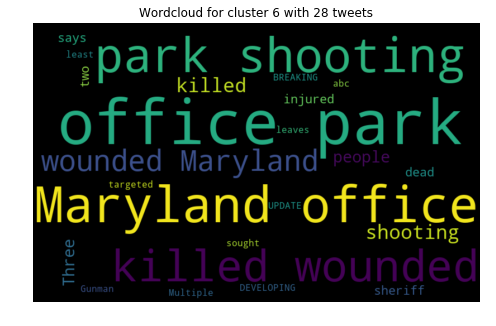

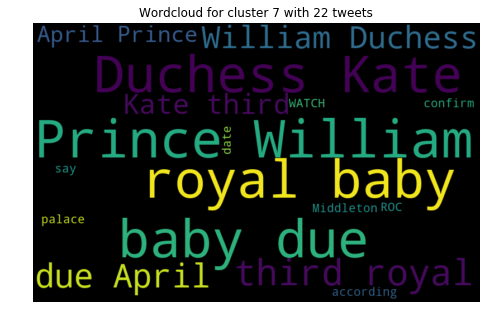

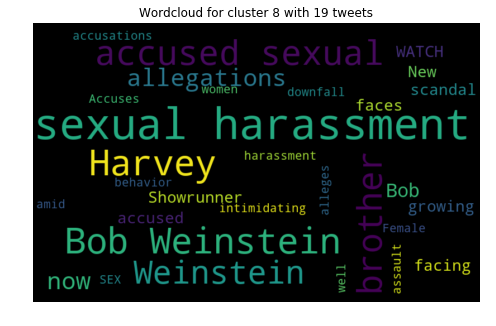

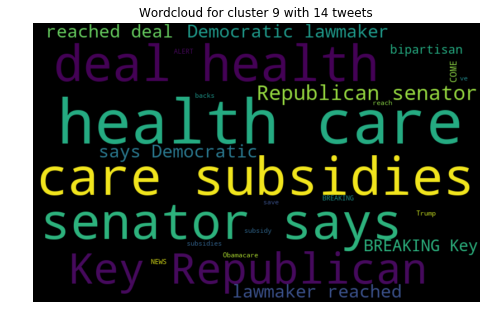

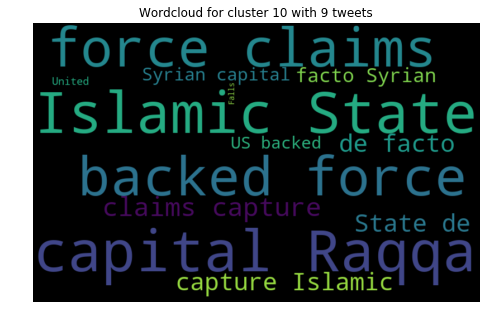

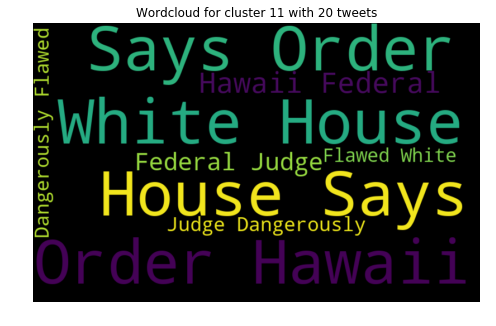

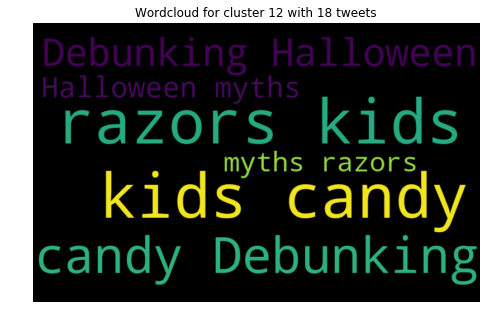

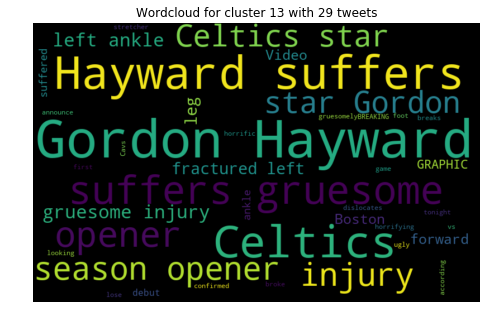

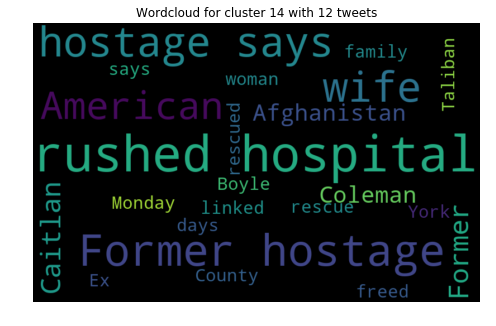

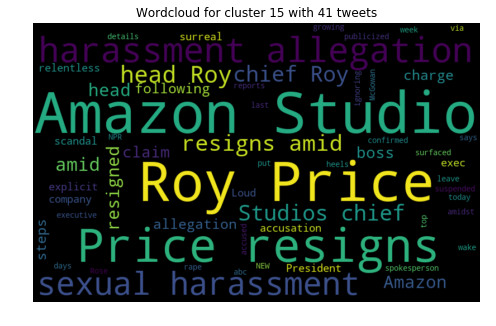

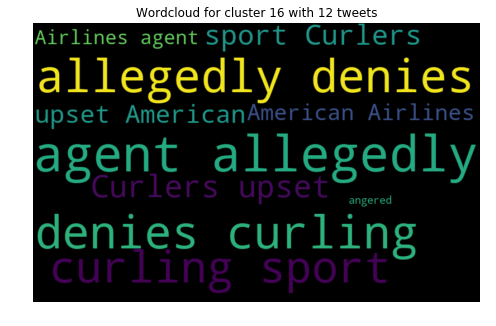

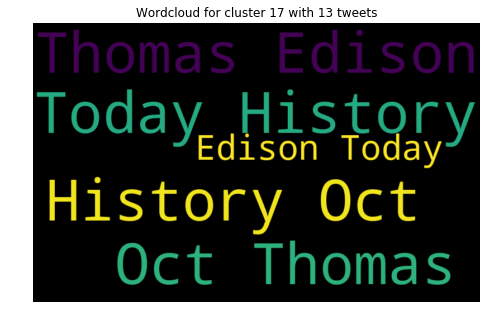

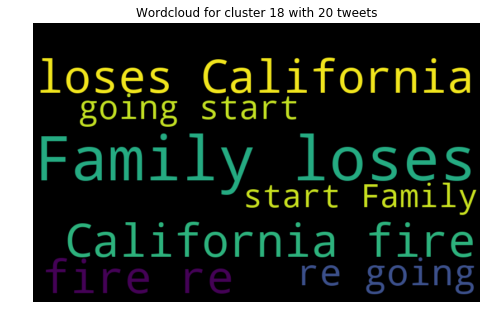

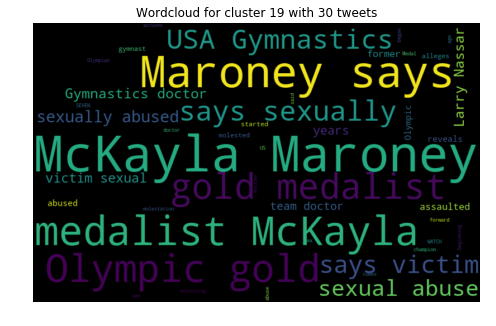

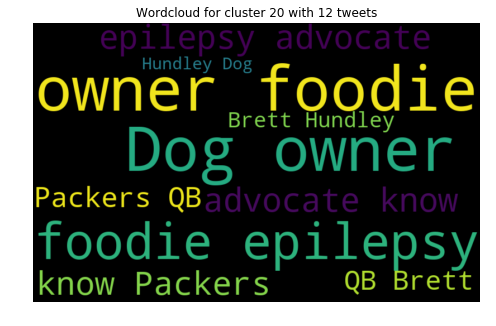

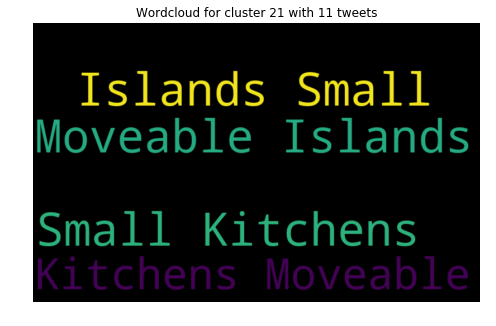

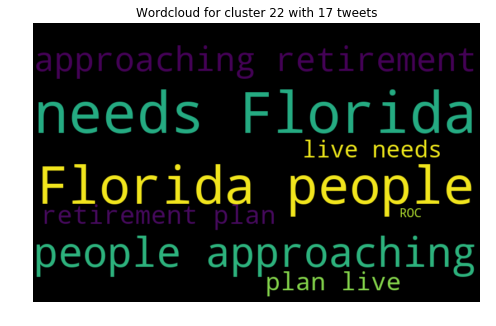

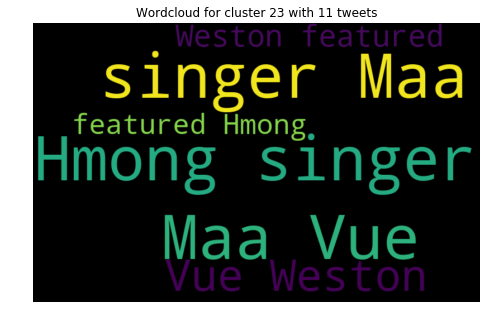

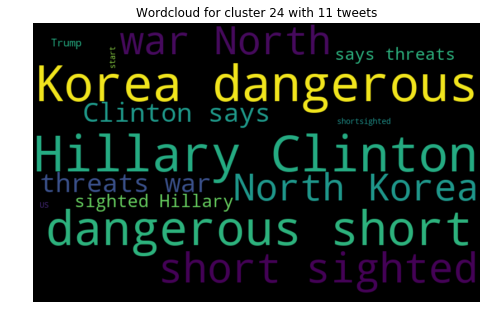

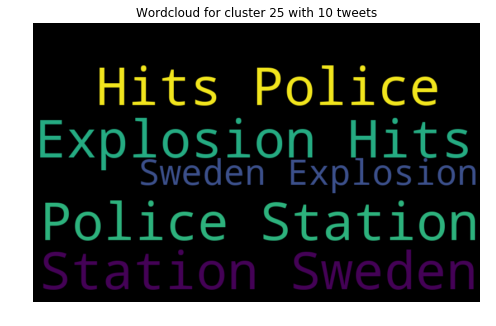

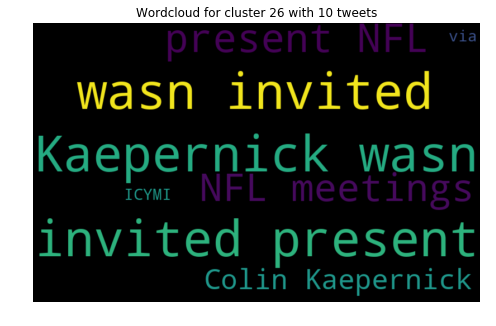

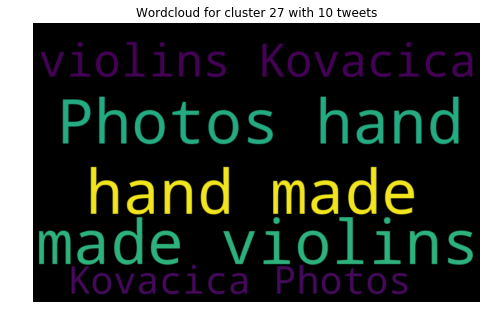

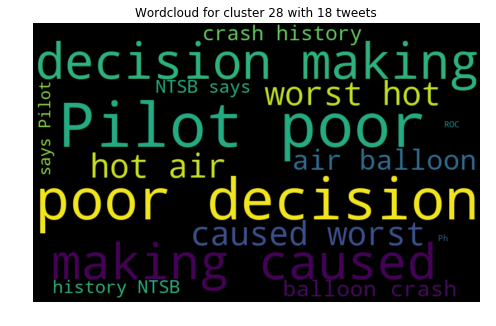

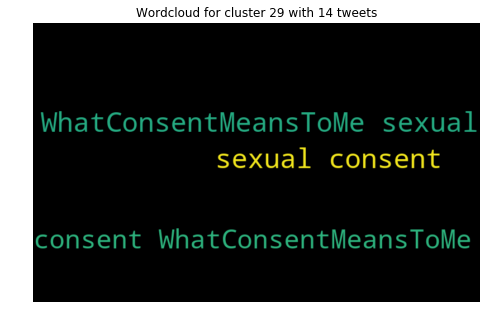

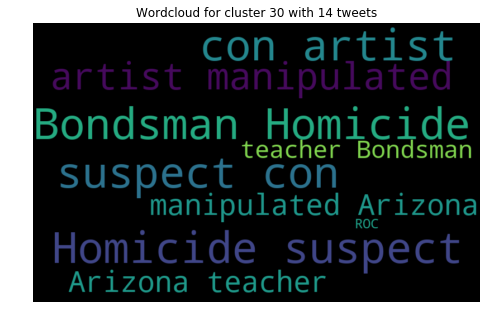

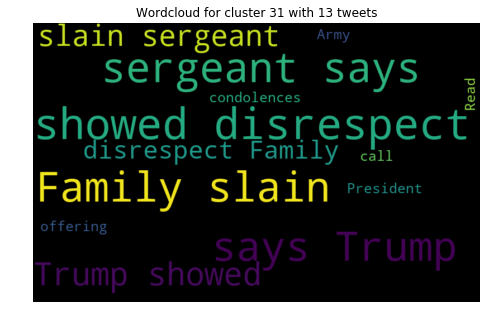

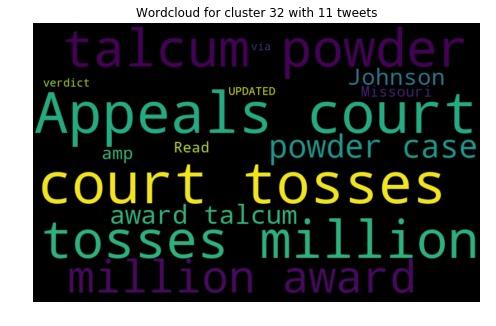

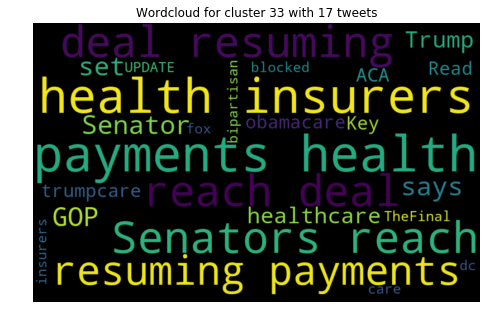

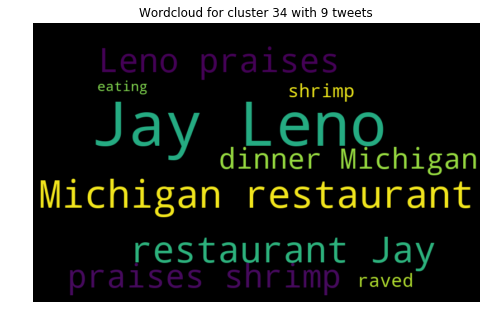

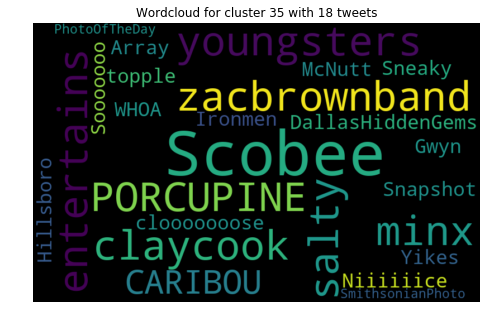

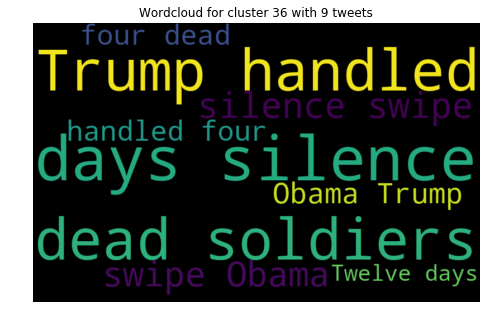

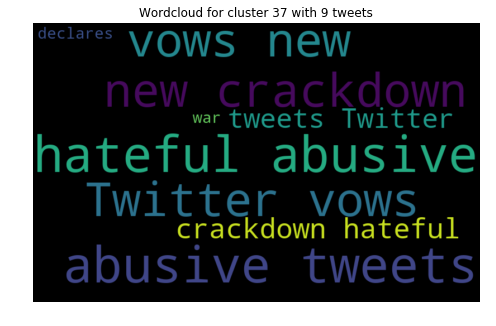

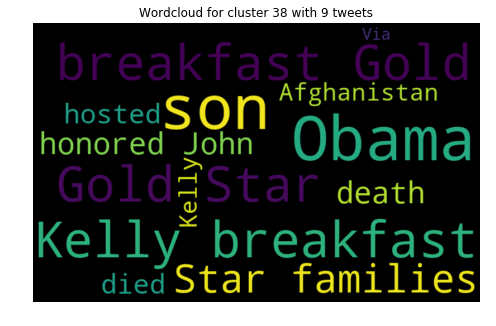

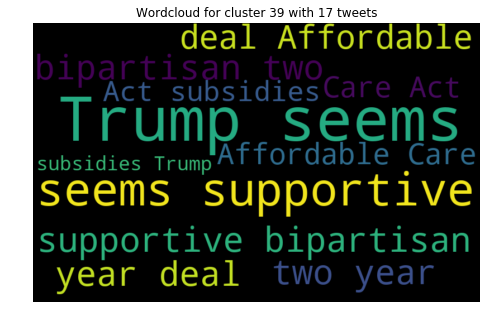

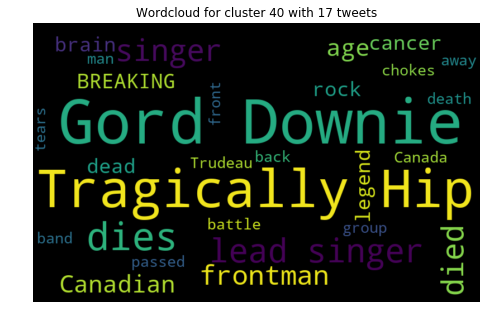

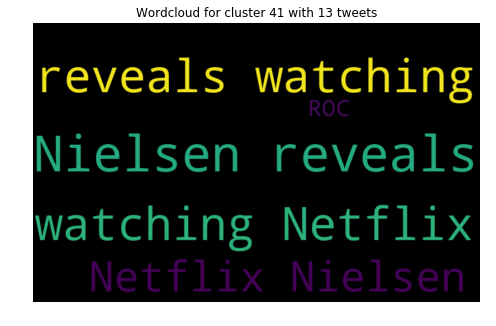

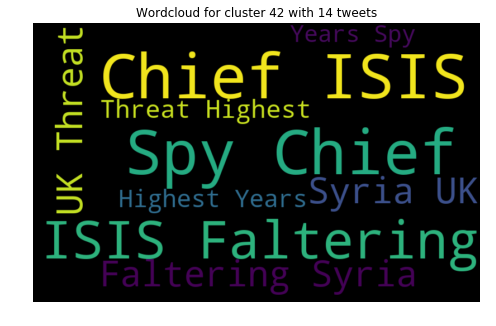

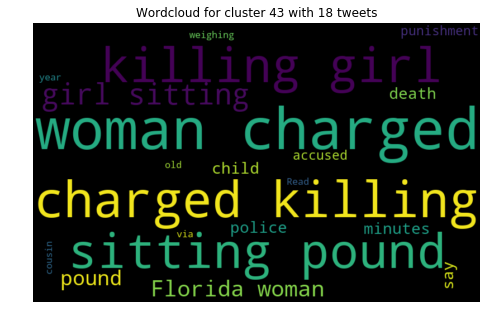

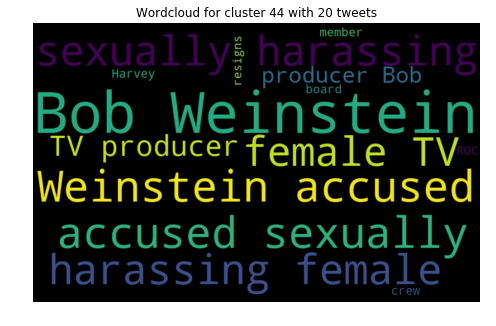

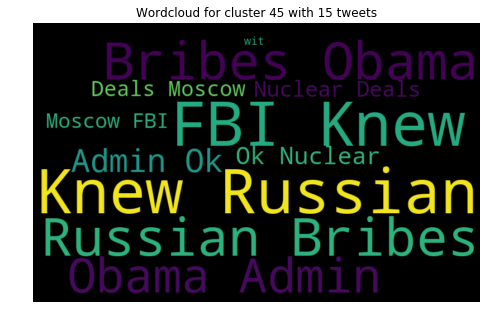

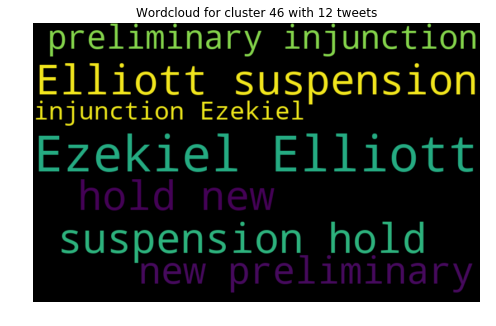

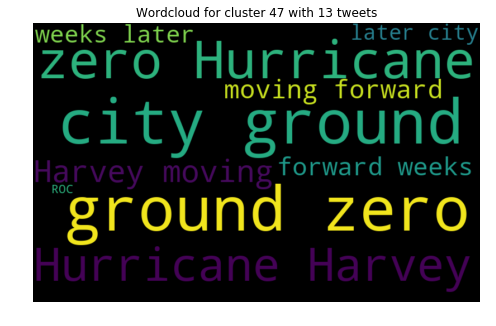

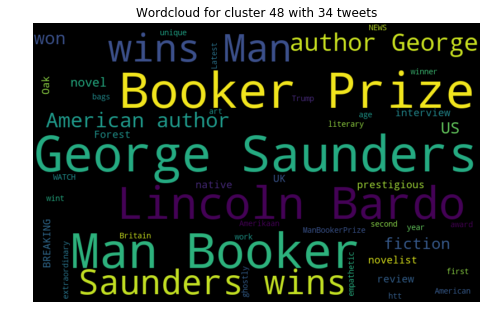

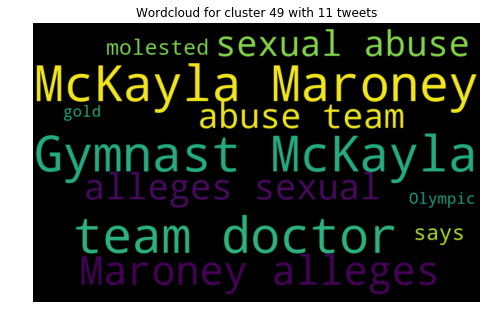

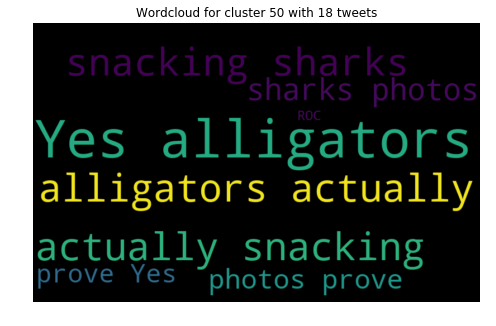

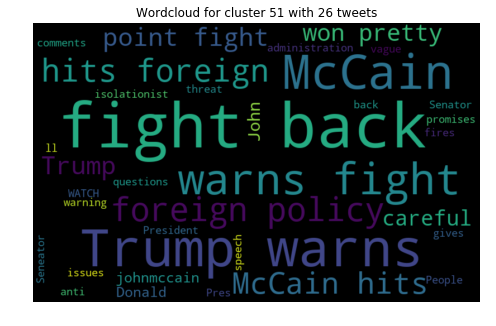

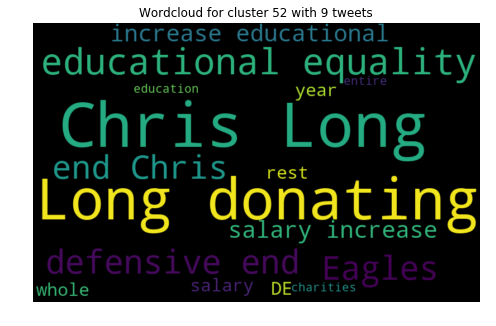

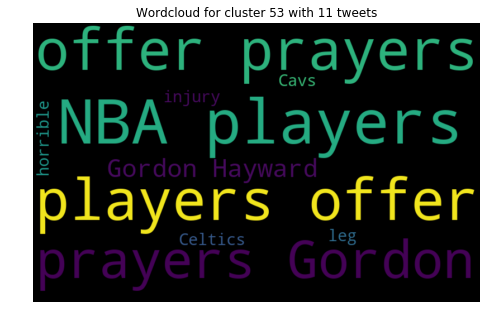

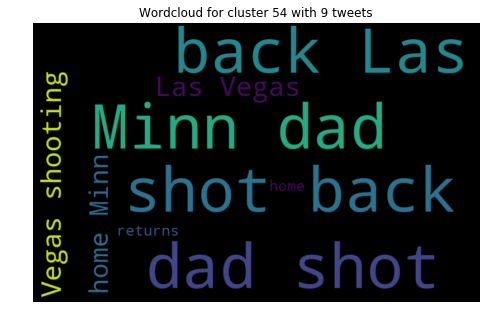

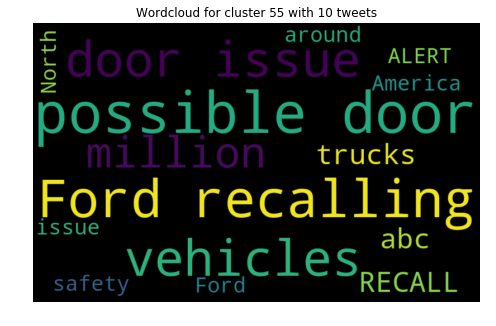

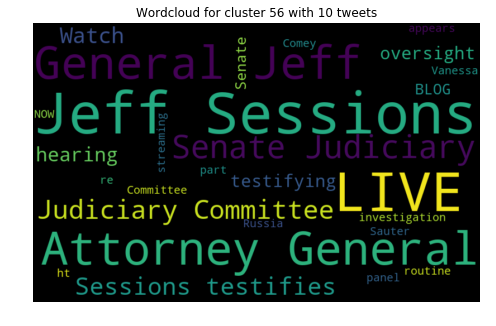

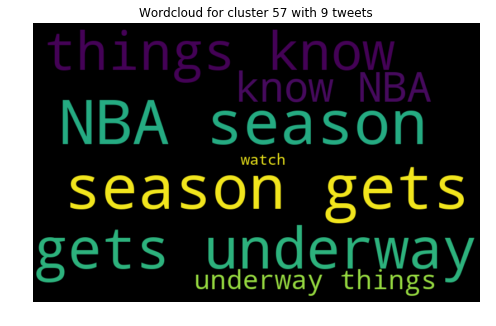

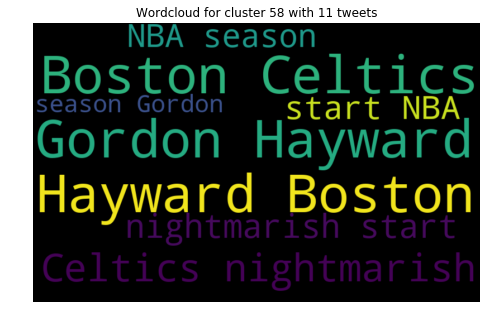

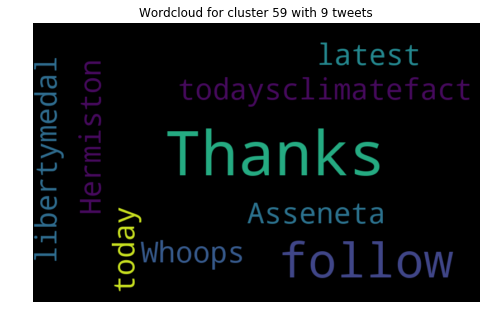

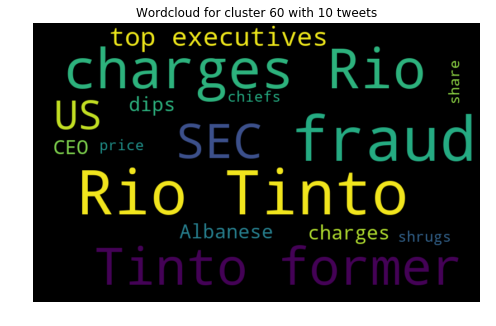

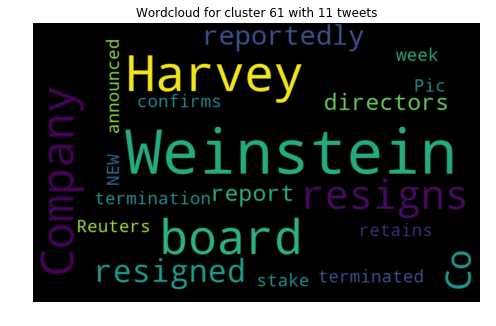

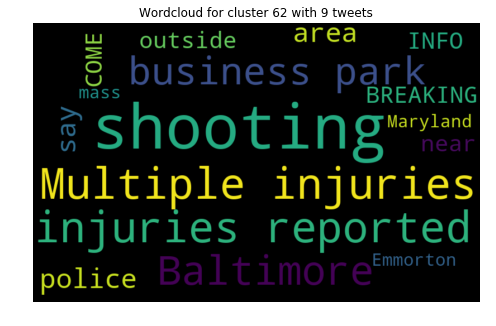

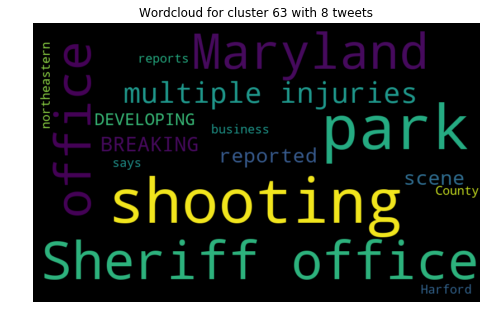

In [66]:
print_word_cloud(n_clusters_, dbscan.labels_, train_X)

In [ ]:
plot_tsne_pca(text, dbscan.labels_)

In [ ]:
plt.hist(clusters, bins=N_CLUSTERS)
plt.show()